In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from joblib import parallel_backend

import pandas as pd
import numpy as np

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score
from sklearn.utils import resample

from chesswinnerprediction.baseline.constants import BASELINE_RANDOM_STATE
from chesswinnerprediction.constants import (
    DRAW_STR,
    BLACK_WIN_STR,
    WHITE_WIN_STR,
    PROCESSED_FOLDER_PATH,
)
from chesswinnerprediction.baseline.utils import (
    estimate_baseline_model,
    get_x_and_y,
    transform_and_scale_df,
)

## Load Data

In [3]:
data_dir = "lichess_db_standard_rated_2017-05"
data_path = os.path.join(PROCESSED_FOLDER_PATH, data_dir)

In [4]:
train_df = pd.read_csv(os.path.join(data_path, "train.csv"))
valid_df = pd.read_csv(os.path.join(data_path, "valid.csv"))

In [5]:
std_scaler = StandardScaler()
train_data = transform_and_scale_df(train_df, std_scaler)
valid_data = transform_and_scale_df(valid_df, std_scaler, fit_scaler=False)

In [6]:
X_train, y_train = get_x_and_y(train_data, predict_draws=True)
X_valid, y_valid = get_x_and_y(valid_data, predict_draws=True)

## KNN Implementation

In [26]:
class CustomKNNClassifier(BaseEstimator, ClassifierMixin):
    classes_ = [DRAW_STR, BLACK_WIN_STR, WHITE_WIN_STR]

    def __init__(
        self,
        wins_constant=0.03,
        draws_constant=0.05,
        n_neighbors=100,
        weights="distance",
        score_size=0.1,
        random_state=None,
        leaf_size=30,
    ):
        self.wins_constant = wins_constant
        self.leaf_size = leaf_size
        self.draws_constant = draws_constant
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.score_size = score_size
        self.random_state = random_state
        self.knn = KNeighborsClassifier(
            n_neighbors=n_neighbors, weights=weights, n_jobs=-1, leaf_size=leaf_size
        )

    def balance_dataset(self, train_data_df):
        draws = train_data_df[train_data_df["Result"] == DRAW_STR]
        black_win = train_data_df[train_data_df["Result"] == BLACK_WIN_STR]
        white_win = train_data_df[train_data_df["Result"] == WHITE_WIN_STR]

        n_draws = int(draws.shape[0] * (1 + self.draws_constant))
        n_black_wins = n_white_wins = int(n_draws * (1 + self.wins_constant))

        draws_oversample = resample(
            draws, replace=True, n_samples=n_draws, random_state=self.random_state
        )
        black_wins_undersample = resample(
            black_win,
            replace=False,
            n_samples=n_black_wins,
            random_state=self.random_state,
        )
        white_wins_undersample = resample(
            white_win,
            replace=False,
            n_samples=n_white_wins,
            random_state=self.random_state,
        )

        balanced_df = pd.concat(
            [draws_oversample, black_wins_undersample, white_wins_undersample]
        )
        return balanced_df

    def fit(self, x, y):
        train_data_df = pd.concat([x, y], axis=1)
        balanced_df = self.balance_dataset(train_data_df)
        X_balanced, y_balanced = (
            balanced_df.drop("Result", axis=1),
            balanced_df["Result"],
        )
        self.knn.fit(X_balanced, y_balanced)
        return self

    def predict(self, x):
        return self.knn.predict(x)

    def predict_proba(self, x):
        return self.knn.predict_proba(x)

    def score(self, x, y, use_subset=True, **kwargs):
        if not use_subset:
            return balanced_accuracy_score(y, self.predict(x))

        subset_size = int(len(x) * self.score_size)
        indices = np.random.choice(len(x), size=subset_size, replace=False)
        X_subset = x.iloc[indices]
        y_subset = y.iloc[indices]

        y_pred = self.predict(X_subset)
        return balanced_accuracy_score(y_subset, y_pred)

In [27]:
param_distributions = {
    "wins_constant": [0.01, 0.1, 0.2, 0.5],
    "draws_constant": [0.01, 0.1, 0.2, 0.5, 1, 2],
    "n_neighbors": [55, 65, 75, 85, 95],
    "weights": ["uniform", "distance"],
    "random_state": [BASELINE_RANDOM_STATE],
}

random_search = RandomizedSearchCV(
    estimator=CustomKNNClassifier(),
    param_distributions=param_distributions,
    n_iter=20,
    scoring=None,
    cv=5,
    random_state=BASELINE_RANDOM_STATE,
    verbose=3,
    n_jobs=-1,
    error_score="raise",
    return_train_score=False,
)

In [ ]:
with parallel_backend("multiprocessing"):
    random_search.fit(X_train, y_train)

In [29]:
random_search.best_score_

np.float64(0.447698955214544)

In [11]:
random_search.best_params_

{'wins_constant': 0.2,
 'weights': 'distance',
 'random_state': 42,
 'n_neighbors': 55,
 'draws_constant': 0.2}

## Best KNN model

In [30]:
args = {
    "wins_constant": 0.1,
    "weights": "uniform",
    "random_state": 42,
    "n_neighbors": 75,
    "draws_constant": 0.5,
    "leaf_size": 30,
}

knn = CustomKNNClassifier(**args)

In [31]:
knn = knn.fit(X_train, y_train)

In [32]:
knn.score(X_valid, y_valid, use_subset=False)

np.float64(0.4583528349325734)

Log Loss on test data: 1.0217
Balanced Accuracy on test data: 45.84%


                                                Classification Report
                         Train Report                                      Validation Report
              precision    recall  f1-score   support         precision    recall  f1-score   support
         0-1       0.58      0.46      0.51    378005              0.58      0.45      0.51     45215
         1-0       0.61      0.43      0.50    392248              0.61      0.43      0.51     47511
     1/2-1/2       0.05      0.51      0.09     20431              0.05      0.49      0.09      2537
    accuracy                           0.45    790684                                  0.45     95263
   macro avg       0.41      0.47      0.37    790684              0.41      0.46      0.37     95263
weighted avg       0.58      0.45      0.50    790684              0.58      0.45      0.50     95263
       


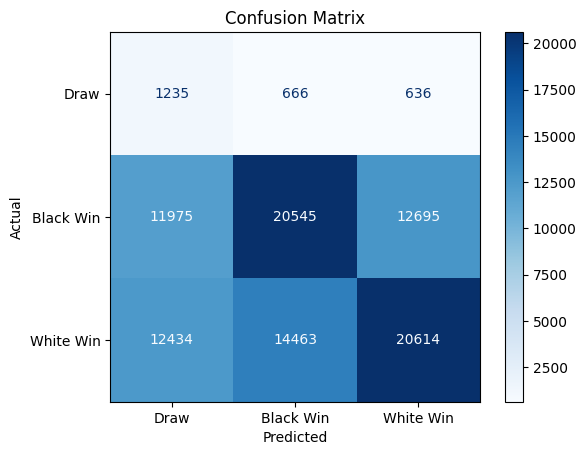

In [33]:
feature_importance = None
estimate_baseline_model(knn, feature_importance, X_train, y_train, X_valid, y_valid)